In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import DBSCAN
from fuzzywuzzy import fuzz

In [36]:
# Load Dataset
df = pd.read_csv('dataset_01.csv')

# Select Relevant Fields
df = df[['fldVendorNo', 'fldInvoiceDate', 'fldInvoiceAmount', 'fldVendorName', 'fldTransactions']]

# Convert InvoiceDate to datetime
df['fldInvoiceDate'] = pd.to_datetime(df['fldInvoiceDate'], format='mixed')

# Handle missing values (drop or impute)
df = df.dropna(subset=['fldVendorNo', 'fldInvoiceDate', 'fldInvoiceAmount'])

# Sort by Vendor ID and Invoice Date
df = df.sort_values(by=['fldVendorNo', 'fldInvoiceDate'])

In [37]:
# Calculate Rolling Statistics
rolling_window = 3  # Adjust the window size as needed
df['RollingMean'] = df.groupby('fldVendorNo')['fldInvoiceAmount'].transform(lambda x: x.rolling(rolling_window, min_periods=1).mean())
df['RollingStd'] = df.groupby('fldVendorNo')['fldInvoiceAmount'].transform(lambda x: x.rolling(rolling_window, min_periods=1).std())

# Calculate Deviation
df['Deviation'] = df['fldInvoiceAmount'] - df['RollingMean']

# Threshold-Based Anomaly Detection
# threshold_factor = 9  # Adjust threshold multiplier as needed
# df['Anomaly_Threshold'] = np.where(df['Deviation'] > threshold_factor * df['RollingStd'], 'Anomaly', 'Normal')


In [38]:
# Prepare Data for One-Class SVM
features = ['RollingMean', 'RollingStd', 'Deviation']
df = df.dropna(subset=features)  # Ensure no NaN in features
X = df[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [39]:
# Train One-Class SVM
oc_svm = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.1)
df['Anomaly_SVM'] = oc_svm.fit_predict(X_scaled)

# Interpret SVM Results (-1 = Anomaly, 1 = Normal)
df['Anomaly_SVM_Label'] = df['Anomaly_SVM'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')


In [14]:
# Visualizations
# Plot Threshold-Based Anomaly Detection (Scatter Plot)
# plt.figure(figsize=(12, 6))
# for vendor in df['fldVendorNo'].unique():
#     vendor_data = df[df['fldVendorNo'] == vendor]
#     plt.scatter(vendor_data['fldInvoiceDate'], vendor_data['fldInvoiceAmount'], label=f"Vendor {vendor}", alpha=0.5, color='blue')
#     plt.scatter(
#         vendor_data[vendor_data['Anomaly_Threshold'] == 'Anomaly']['fldInvoiceDate'],
#         vendor_data[vendor_data['Anomaly_Threshold'] == 'Anomaly']['fldInvoiceAmount'],
#         color='red', label=f"Anomalies (Vendor {vendor})", s=100, marker='x'
#     )

# plt.title("Threshold-Based Anomaly Detection (Scatter Plot)")
# plt.xlabel("Invoice Date")
# plt.ylabel("Invoice Amount")
# # plt.legend()
# plt.grid(True)
# plt.show()

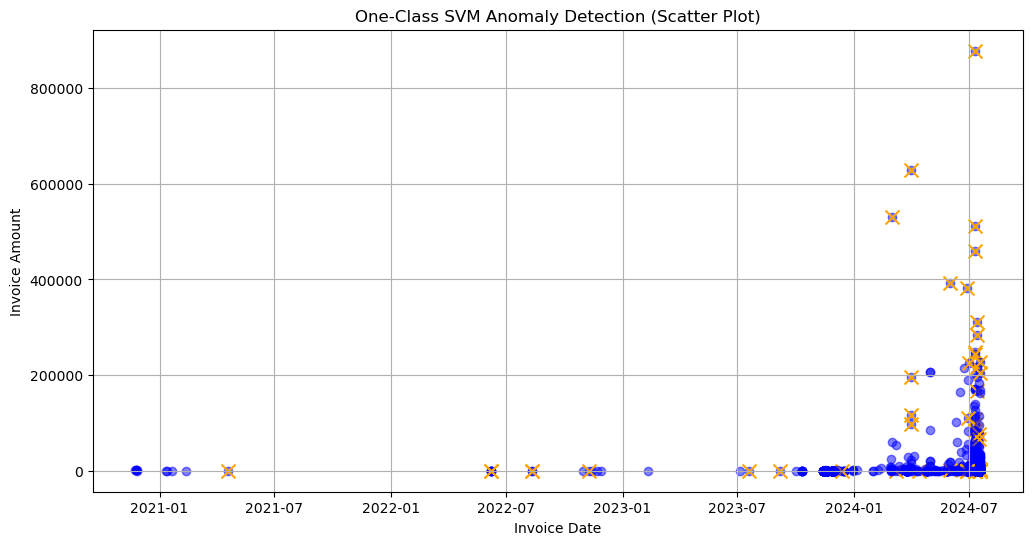

In [40]:
# Plot One-Class SVM Anomaly Detection (Scatter Plot)
plt.figure(figsize=(12, 6))
for vendor in df['fldVendorNo'].unique():
    vendor_data = df[df['fldVendorNo'] == vendor]
    plt.scatter(vendor_data['fldInvoiceDate'], vendor_data['fldInvoiceAmount'], label=f"Vendor {vendor}", alpha=0.5, color='blue')
    plt.scatter(
        vendor_data[vendor_data['Anomaly_SVM_Label'] == 'Anomaly']['fldInvoiceDate'],
        vendor_data[vendor_data['Anomaly_SVM_Label'] == 'Anomaly']['fldInvoiceAmount'],
        color='orange', label=f"SVM Anomalies (Vendor {vendor})", s=100, marker='x'
    )

plt.title("One-Class SVM Anomaly Detection (Scatter Plot)")
plt.xlabel("Invoice Date")
plt.ylabel("Invoice Amount")
# plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Output Results
# Save the results to a CSV
df[['fldVendorNo', 'fldInvoiceDate', 'fldInvoiceAmount', 'Anomaly_Threshold', 'Anomaly_SVM_Label']].to_csv('anomaly_detection_results.csv', index=False)

In [45]:
# def detect_currency_anomalies(df):
#     # Group by Vendor and get currency distribution
#     currency_counts = df.groupby(['fldVendorNo', 'fldTransactions']).size().unstack(fill_value=0)
    
#     # Calculate currency usage percentages
#     currency_percentages = currency_counts.div(currency_counts.sum(axis=1), axis=0)
    
#     # Prepare features for One-Class SVM
#     X_currency = currency_percentages.values
    
#     # Scale features
#     scaler = StandardScaler()
#     X_currency_scaled = scaler.fit_transform(X_currency)
    
#     # Train One-Class SVM
#     oc_svm_currency = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
#     currency_anomalies = oc_svm_currency.fit_predict(X_currency_scaled)
    
#     # Create a mapping of vendor to currency anomaly status
#     currency_anomaly_mapping = dict(zip(currency_percentages.index, 
#                                         ['Currency Anomaly' if x == -1 else 'Normal' for x in currency_anomalies]))
    
#     # Add currency anomaly labels to original DataFrame
#     df['Currency_Anomaly'] = df['fldVendorNo'].map(currency_anomaly_mapping)
    
#     return df
def detect_irregular_currency_pattern(data):
    # Ensure column names are correctly named and clean
    data.columns = data.columns.str.strip()  # Strip any extra spaces in column names
    
    # Step 1: Check if 'Supplier Name' and 'Currency Code' are available
    if 'fldVendorName' not in data.columns or 'fldTransactions' not in data.columns:
        raise ValueError("The dataset must contain 'Supplier Name' and 'Currency Code' columns")
    
    # Step 2: Handle missing values in 'Currency Code' or 'Supplier Name'
    data['fldTransactions'].fillna('Unknown', inplace=True)
    data['fldVendorName'].fillna('Unknown Supplier', inplace=True)
    
    # Step 3: Find the most common currency used by each supplier
    most_common_currency = data.groupby('fldVendorName')['fldTransactions'].agg(lambda x: x.mode()[0] if not x.mode().empty else 'Unknown')

    # Step 4: Create a new column for currency anomalies
    data['Currency Anomaly'] = None
    
    # Step 5: Loop through each supplier and check for anomalies
    for supplier in data['fldVendorName'].unique():
        common_currency = most_common_currency[supplier]
        supplier_data = data[data['fldVendorName'] == supplier]
        
        # Step 6: Flag any invoice that doesn't match the most common currency
        anomaly_rows = supplier_data[supplier_data['fldTransactions'] != common_currency]
        if not anomaly_rows.empty:
            data.loc[anomaly_rows.index, 'Currency Anomaly'] = f"Irregular currency: {common_currency} vs {anomaly_rows['fldTransactions'].values[0]}"
    
    return data

In [46]:
def detect_vendor_name_anomalies(df):
    # Get unique vendor names
    unique_vendors = df['fldVendorName'].unique()
    
    # Create a similarity matrix using fuzzy string matching
    similarity_matrix = np.zeros((len(unique_vendors), len(unique_vendors)))
    for i in range(len(unique_vendors)):
        for j in range(len(unique_vendors)):
            similarity_matrix[i, j] = fuzz.ratio(unique_vendors[i], unique_vendors[j])
    
    # Apply DBSCAN for clustering vendor names
    dbscan = DBSCAN(eps=20, min_samples=1, metric='precomputed')
    vendor_clusters = dbscan.fit_predict(100 - similarity_matrix)
    
    # Create a mapping of vendor names to anomaly labels
    vendor_anomaly_mapping = {}
    for cluster in set(vendor_clusters):
        if cluster == -1:  # Noise points are considered anomalies
            cluster_vendors = unique_vendors[vendor_clusters == cluster]
            for vendor in cluster_vendors:
                vendor_anomaly_mapping[vendor] = 'Vendor Name Anomaly'
    
    # Default to 'Normal' for vendors not in anomaly mapping
    vendor_anomaly_mapping = {k: vendor_anomaly_mapping.get(k, 'Normal') for k in unique_vendors}
    
    # Add vendor name anomaly labels to original DataFrame
    df['Vendor_Name_Anomaly'] = df['fldVendorName'].map(vendor_anomaly_mapping)
    
    return df

In [47]:
# Detect Currency Anomalies
# df = detect_currency_anomalies(df)
df = detect_irregular_currency_pattern(df)

# Detect Vendor Name Anomalies
df = detect_vendor_name_anomalies(df)

C:\Users\Dhireen Kumar Rajak\AppData\Local\Temp\ipykernel_14188\1621303239.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['fldTransactions'].fillna('Unknown', inplace=True)
C:\Users\Dhireen Kumar Rajak\AppData\Local\Temp\ipykernel_14188\1621303239.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

In [49]:
# Save results
df.to_csv('comprehensive_anomaly_results.csv', index=False)